In [1]:
try:
    import cPickle as pickle
except:
    import pickle
import glob
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import lasagne
from lasagne import layers
from lasagne import nonlinearities
from nolearn.lasagne import NeuralNet, TrainSplit
from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn import tree
from sklearn.learning_curve import validation_curve, learning_curve

from create_and_train import EarlyStopping
from constant import Y_COLUMNS
from lignet_utils import gen_train_test, load_nets, calc_r_squared
from lignet_utils import print_r_squared, transform_pred_to_actual
from lignet_utils import calc_r_squared_dt

%matplotlib inline

In [2]:
params = {
    'axes.labelsize': 10,
    'font.size': 10,
    'legend.fontsize': 10,
    'axes.titlesize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'text.usetex': False
   }
plt.rcParams.update(params)

In [3]:
x_train, x_test, y_train, y_test, x_scaler, y_scaler = gen_train_test()

nets = load_nets('trained_networks/final*')
full_net = load_nets('trained_networks/full*')

with open('trained_networks/decision_tree.pkl', 'rb') as pkl:
    dtr_full = pickle.load(pkl)[0]

In [5]:
# Decision tree learning curve
train_size = int(1 * x_train.shape[0])
xt = x_train[:train_size, :]
yt = y_train[:train_size, :]

dt_train_sizes, train_scores, valid_scores = learning_curve(
    tree.DecisionTreeRegressor(max_depth=26, min_samples_leaf=2), xt, yt,
    train_sizes=[100, 500, 1500, 5000, 75000, 133333],
    scoring='mean_squared_error')

dt_train_scores_mean = np.mean(train_scores, axis=1)
dt_train_scores_std = np.std(train_scores, axis=1)
dt_valid_scores_mean = np.mean(valid_scores, axis=1)
dt_valid_scores_std = np.std(valid_scores, axis=1)

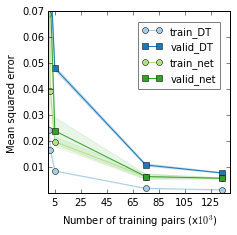

In [12]:
plt.figure(figsize=(3.26, 3.26), dpi=1200)

plt.plot(dt_train_sizes, -dt_train_scores_mean, 'o-', label='train_DT',
         color='#a6cee3')
plt.fill_between(dt_train_sizes, -dt_train_scores_mean - dt_train_scores_std,
                -dt_train_scores_mean + dt_train_scores_std, alpha=0.2,
                 color='#a6cee3')
plt.plot(dt_train_sizes, -dt_valid_scores_mean, 'o-', label='valid_DT',
         color='#1f78b4', marker='s')
plt.fill_between(dt_train_sizes, -dt_valid_scores_mean - dt_valid_scores_std,
                -dt_valid_scores_mean + dt_valid_scores_std, alpha=0.2,
                 color='#1f78b4')

# add the curves for the full net
with open('learning_curve.pkl', 'rb') as pkl:
    (train_scores_mean, train_scores_std, valid_scores_mean,
     valid_scores_std, train_sizes) = pickle.load(pkl)
    
plt.plot(train_sizes, -train_scores_mean, 'o-', label='train_net',
         color='#b2df8a')
plt.fill_between(train_sizes, -train_scores_mean - train_scores_std,
                -train_scores_mean + train_scores_std, alpha=0.2,
                 color='#b2df8a')
plt.plot(train_sizes, -valid_scores_mean, 'o-', label='valid_net',
         color='#33a02c', marker='s')
plt.fill_between(train_sizes, -valid_scores_mean - valid_scores_std,
                -valid_scores_mean + valid_scores_std, alpha=0.1,
                 color='#33a02c')
plt.legend(framealpha=0.5, bbox_to_anchor=(0.97, 0.97))
plt.xlabel("Number of training pairs (x$10^3$)")
plt.ylabel("Mean squared error")
plt.axis([0, 140000, 0, 0.07])
plt.yticks([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07])
# plt.xticks([5000, 75000, 133333])
plt.xticks([5000, 25000, 45000, 65000, 85000, 105000, 125000],
          ['5', '25', '45', '65', '85', '105', '125'])
plt.savefig('learning_curve.tiff', bbox_inches = 'tight', dpi=600)

In [13]:
def pplot_one_output_full(ax, yt, yv, ytest, ytpred, yvpred, ytestpred,
                          output_col, axis, ub=None):
    """
    Make a parity plot for the training (blue), validation(green),
    and test (red) set predictions of a specific output measure within the
    full network (trained on all the output measures at once).

    Parameters
    ----------
    ax         : matplotlib.axes._subplots.AxesSubplot
                 axes object to plot on
    yt         : numpy ndarray
                 training set actual values
    yv         : numpy ndarray
                 validation set actual values
    ytest      : numpy ndarray
                 test set actual values
    ytpred     : numpy ndarray
                 training set predicted values
    yvpred     : numpy ndarray
                 validation set predicted values
    ytestpred  : numpy ndarray
                 test set predicted values
    output_col : int
                 the column of the output measure you want to plot
    axis       : int
                 which ax object to place this plot in
    ub         : int
                 the number of points you would like to include in plot

    Returns
    -------
    None
    """
    if ub is None:
        ub = ytpred.shape[0]
    ax[axis].plot([np.min(yt[:ub, output_col]),
                         np.max(yt[:ub, output_col])],
                        [np.min(yt[:ub, output_col]),
                         np.max(yt[:ub, output_col])], c='black')
    ax[axis].scatter(ytpred[:ub, output_col].flatten(),
                           yt[:ub, output_col].flatten(),
                           s=0.1, alpha=0.2,
                           c='#a6cee3', marker='x', label='train')
    ax[axis].scatter(yvpred[:ub, output_col].flatten(),
                           yv[:ub, output_col].flatten(),
                           s=0.1, alpha=0.2,
                           c='#1f78b4', marker='x', label='validation')
    ax[axis].scatter(ytestpred[:ub, output_col].flatten(),
                           ytest[:ub, output_col].flatten(),
                           s=0.1, alpha=0.2,
                           c='#b2df8a', marker='x', label='test')
    ax[axis].set_title('%s' % Y_COLUMNS[output_col])
    ax[axis].set_xlim([1.25 * np.min(yt[:ub, output_col]),
                       1.25 * np.max(yt[:ub, output_col])])
    ax[axis].set_ylim([1.25 * np.min(yt[:ub, output_col]),
                       1.25 * np.max(yt[:ub, output_col])])
    subplot_labels = ['A', 'B', 'C', 'D']
    if axis in set([0, 1]):
        ax[axis].text(0.95 * np.min(yt[:ub, output_col]),
                      0.93 * np.max(yt[:ub, output_col]),
                      '%s' % subplot_labels[axis], fontsize=14)
    else:
        ax[axis].text(0.9 * np.min(yt[:ub, output_col]),
                      0.99 * np.max(yt[:ub, output_col]),
                      '%s' % subplot_labels[axis], fontsize=14)

    return None

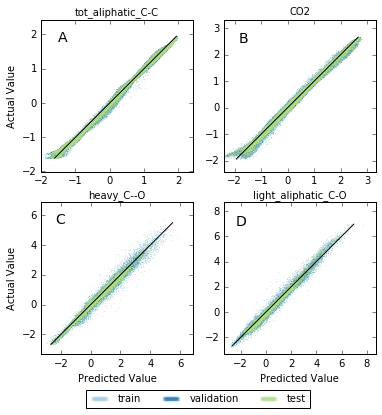

In [14]:
# Parity plots for the output measures in the full network
output_list = [17, 5, 18, 28]
f, ax = plt.subplots(2, 2, sharex=False,
                     sharey=False, figsize=(6, 6))
ax = ax.ravel()

net = full_net['all']
# get the same train/test split that was used in setting up the net
Xt, Xv, yt, yv = net.train_split(x_train, y_train, net)
# calculate the values predicted by the network
ytpred = net.predict(Xt)
yvpred = net.predict(Xv)
ytestpred = net.predict(x_test)

for i, key in enumerate(output_list):
    pplot_one_output_full(ax, yt, yv, y_test, ytpred, yvpred, ytestpred, key, i)
    
ax[len(output_list)-1].set_xlabel('Predicted Value')
ax[len(output_list)-2].set_xlabel('Predicted Value')
# put y-labels on the left hand subplots
for i in range(0, len(output_list), 2):
    ax[i].set_ylabel('Actual Value')
f.subplots_adjust(hspace=0.2, wspace=0.2)
ax[1].legend(scatterpoints=60, markerscale=10, ncol=3,
             bbox_to_anchor=(0.6, -1.4))
f.savefig('full_net_pplot.tiff', bbox_inches = 'tight', dpi=600)

In [15]:
def pplot_one_output(ax, net, x_train, y_train, x_test, y_test, output_col,
                     title, axis, ub=None):
    """
    Make a parity plot for the training (blue), validation (green),
    and test (red) set predictions of a specific output measure.
    This function can be called for a single plot (`f, ax = plt.subplots()`),
    or to plot many subplots in the same figure, but it only works for networks
    that are trained on individual output measures (not the full network).

    Parameters
    ----------
    ax         : matplotlib.axes._subplots.AxesSubplot
                 axes object to plot on
    net        : nolearn.lasagne.base.NeuralNet
                 a trained neural network
    x_train    : numpy.ndarray
                 the scaled training data used for the input layer of the
                 network (standardized to have zero mean and unit variance)
    x_test     : numpy.ndarray
                 scaled data you can use as a test set that the network has
                 never seen before
    y_train    : numpy.ndarray
                 the scaled training data used for the output layer of the
                 network (standardized to have zero mean and unit variance)
    y_test     : numpy.ndarray
                 scaled expected output values that the network has not seen
                 before to use with x_test
    output_col : int
                 the column of the output measure in y_train to plot
    title      : string
                 the name of the output measure being plotted
    ub         : int
                 the number of points you would like to include in plot

    Returns
    -------
    None
    """
    # get the same train/test split that was used in setting up the network
    Xt, Xv, yt, yv = net.train_split(x_train, y_train[:, output_col], net)
    # calculate the values predicted by the network
    y_pred_train = net.predict(Xt)
    y_pred_valid = net.predict(Xv)
    y_pred_test = net.predict(x_test)

    if ub is None:
        ub = y_pred_train.shape[0]

    ax[axis].plot([np.min(yt[:ub]), np.max(yt[:ub])],
                        [np.min(yt[:ub]), np.max(yt[:ub])], c='black')
    ax[axis].scatter(y_pred_train[:ub].flatten(),
                           yt[:ub].flatten(),
                           s=0.1, alpha=0.2,
                           c='#a6cee3', marker='x', label='train')
    ax[axis].scatter(y_pred_valid[:ub].flatten(),
                           yv[:ub].flatten(),
                           s=0.1, alpha=0.2,
                           c='#1f78b4', marker='x', label='validation')
    ax[axis].scatter(y_pred_test[:ub].flatten(),
                           y_test[:ub, output_col].flatten(),
                           s=0.1, alpha=0.2,
                           c='#b2df8a', marker='x', label='test')
    ax[axis].set_title('%s' % title)

    ax[axis].set_xlim([1.25 * np.min(yt[:ub]),
                       1.25 * np.max(yt[:ub])])
    ax[axis].set_ylim([1.25 * np.min(yt[:ub]),
                       1.25 * np.max(yt[:ub])])
    subplot_labels = ['A', 'B', 'C', 'D']
    if axis in set([0, 1]):
        ax[axis].text(0.95 * np.min(yt[:ub]),
                      0.93 * np.max(yt[:ub]),
                      '%s' % subplot_labels[axis], fontsize=14)
    else:
        ax[axis].text(0.9 * np.min(yt[:ub]),
                      0.99 * np.max(yt[:ub]),
                      '%s' % subplot_labels[axis], fontsize=14)

    return None

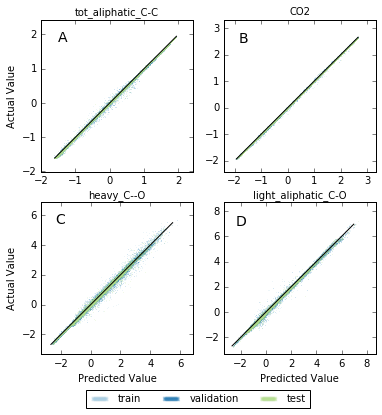

In [16]:
# Plot all the individually trained networks
output_list = [17, 5, 18, 28]
f, ax = plt.subplots(2, 2, sharex=False,
                     sharey=False, figsize=(6, 6))
ax = ax.ravel()

for i, key in enumerate(output_list):
    title = Y_COLUMNS[key]
    net = nets[key]
    pplot_one_output(ax, net, x_train, y_train, x_test, y_test, key, title, i)
    
ax[len(output_list)-1].set_xlabel('Predicted Value')
ax[len(output_list)-2].set_xlabel('Predicted Value')
# put y-labels on the left hand subplots
for i in range(0, len(output_list), 2):
    ax[i].set_ylabel('Actual Value')
f.subplots_adjust(hspace=0.2, wspace=0.2)
ax[1].legend(scatterpoints=60, markerscale=10, ncol=3,
             bbox_to_anchor=(0.6, -1.4))
# ax[3].set_xlim([-5, 1.15 * np.max(yt[:])])
# ax[3].set_ylim([-5, 1.15 * np.max(yt[:])])
# ax[1].set_xticks([-1, 0, 1, 2])
# ax[1].set_yticks([-1, 0, 1, 2])
f.savefig('single_nets_pplot.tiff', bbox_inches = 'tight', dpi=600)

In [62]:
for i, name in enumerate(Y_COLUMNS):
    print i, name

In [17]:
def pplot_dt_full(ax, yt, yv, ytest, ytpred, yvpred, ytestpred,
                          output_col, axis, ub=None):
    """
    Make a parity plot for the training (blue), validation(green),
    and test (red) set predictions of a specific output measure within the
    full network (trained on all the output measures at once).

    Parameters
    ----------
    ax         : matplotlib.axes._subplots.AxesSubplot
                 axes object to plot on
    yt         : numpy ndarray
                 training set actual values
    yv         : numpy ndarray
                 validation set actual values
    ytest      : numpy ndarray
                 test set actual values
    ytpred     : numpy ndarray
                 training set predicted values
    yvpred     : numpy ndarray
                 validation set predicted values
    ytestpred  : numpy ndarray
                 test set predicted values
    output_col : int
                 the column of the output measure you want to plot
    axis       : int
                 which ax object to place this plot in
    ub         : int
                 the number of points you would like to include in plot

    Returns
    -------
    None
    """
    if ub is None:
        ub = ytpred.shape[0]
    ax[axis].plot([np.min(yt[:ub, output_col]),
                         np.max(yt[:ub, output_col])],
                        [np.min(yt[:ub, output_col]),
                         np.max(yt[:ub, output_col])], c='black')
    ax[axis].scatter(ytpred[:ub, output_col].flatten(),
                           yt[:ub, output_col].flatten(),
                           s=0.1, alpha=0.2,
                           c='#a6cee3', marker='x', label='train')
    ax[axis].scatter(yvpred[:ub, output_col].flatten(),
                           yv[:ub, output_col].flatten(),
                           s=0.1, alpha=0.2,
                           c='#1f78b4', marker='x', label='validation')
    ax[axis].scatter(ytestpred[:ub, output_col].flatten(),
                           ytest[:ub, output_col].flatten(),
                           s=0.1, alpha=0.2,
                           c='#b2df8a', marker='x', label='test')
    ax[axis].set_title('%s' % Y_COLUMNS[output_col])
    ax[axis].set_xlim([1.25 * np.min(yt[:ub, output_col]),
                       1.25 * np.max(yt[:ub, output_col])])
    ax[axis].set_ylim([1.25 * np.min(yt[:ub, output_col]),
                       1.25 * np.max(yt[:ub, output_col])])
    subplot_labels = ['A', 'B', 'C', 'D']
    if axis in set([0, 1]):
        ax[axis].text(0.95 * np.min(yt[:ub, output_col]),
                      0.93 * np.max(yt[:ub, output_col]),
                      '%s' % subplot_labels[axis], fontsize=14)
    else:
        ax[axis].text(0.9 * np.min(yt[:ub, output_col]),
                      0.99 * np.max(yt[:ub, output_col]),
                      '%s' % subplot_labels[axis], fontsize=14)

    return None

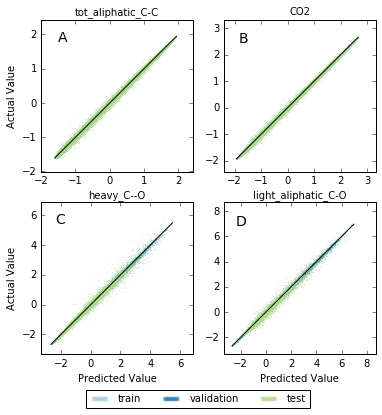

In [19]:
# Parity plots for the output measures in the decision tree
output_list = [17, 5, 18, 28]
f, ax = plt.subplots(2, 2, sharex=False,
                     sharey=False, figsize=(6, 6))
ax = ax.ravel()

net = full_net['all']
# get the same train/test split that was used in setting up the net
Xt, Xv, yt, yv = net.train_split(x_train, y_train, net)
# calculate the values predicted by the network
ytpred = dtr_full.predict(Xt)
yvpred = dtr_full.predict(Xv)
ytestpred = dtr_full.predict(x_test)

for i, key in enumerate(output_list):
    pplot_dt_full(ax, yt, yv, y_test, ytpred, yvpred, ytestpred, key, i)
    
ax[len(output_list)-1].set_xlabel('Predicted Value')
ax[len(output_list)-2].set_xlabel('Predicted Value')
# put y-labels on the left hand subplots
for i in range(0, len(output_list), 2):
    ax[i].set_ylabel('Actual Value')
f.subplots_adjust(hspace=0.2, wspace=0.2)
ax[1].legend(scatterpoints=60, markerscale=10, ncol=3,
             bbox_to_anchor=(0.6, -1.4))
f.savefig('dt_pplot.tiff', bbox_inches = 'tight', dpi=600)